1. Import Libraries / Dependencies

In [1]:
import cv2
import numpy as np
from itertools import chain
import csv
import os

In [2]:
from cvzone.HandTrackingModule import HandDetector
from cvzone.FaceDetectionModule import FaceDetector
from cvzone.PoseModule import PoseDetector

2. Hand, Face and Pose Detection + Feature Extraction

In [3]:
def flatten2dList(arr, dataType=int):
    return np.fromiter(chain.from_iterable(arr), dataType)

In [4]:
def getAbsLargestVal(arr):
    return max(np.max(arr), abs(np.min(arr)))

In [5]:
def preprocess_landmarks(landmark_list):
    if not landmark_list:
        return []
    
    # Offset every point with respect to the first point
    new_landmark_list = []
    origin_x = landmark_list[0][0] 
    origin_y = landmark_list[0][1]
    origin_z = landmark_list[0][2]
    for each in landmark_list:
        updated_point = [
            each[0] - origin_x, 
            each[1] - origin_y, 
            each[2] - origin_z
        ]
        new_landmark_list.append(updated_point)
    
    # Convert to 1D-array
    new_landmark_list = flatten2dList(new_landmark_list)
    
    # Get highest absolute value
    largest_value = getAbsLargestVal(new_landmark_list)
    
    # Normalization
    return new_landmark_list / largest_value


In [6]:
def preprocess_bbox(bbox, frameSize):
    bbox = np.array(bbox, dtype=float)
    # Convert 3rd and 4th element into coordinates instead of width/height
    bbox[2] = bbox[0] + bbox[2]
    bbox[3] = bbox[1] + bbox[3]

    # Normalize against frame size
    bbox[0] /= frameSize[0]
    bbox[2] /= frameSize[0]
    bbox[1] /= frameSize[1]
    bbox[3] /= frameSize[1]

    return bbox

In [7]:
def preprocess_center(center, frameSize):
    center = np.array(center)
    center[0] /= frameSize[0]
    center[1] /= frameSize[1]
    return center

In [8]:
def preprocess_body_part(bodyPart, frameSize):
    bodyPart['lmList'] = preprocess_landmarks(bodyPart['lmList'])
    bodyPart['bbox'] = preprocess_bbox(bodyPart['bbox'], frameSize)
    bodyPart['center'] = preprocess_center(bodyPart['center'], frameSize)
    return bodyPart

In [9]:
def generate_empty_hand(type):
    return {
        'lmList': np.zeros(21 * 3, dtype=int), 
        'bbox': np.zeros(4, dtype=float), 
        'center': np.zeros(2, dtype=float), 
        'type': type
    }

In [10]:
def select_best_matching_face(faces, frameSize):
    if not faces:
        return False
    elif len(faces) == 1:
        return faces[0]
    
    def difference(a, b):
        return (a[0] - b[0])**2 + (a[1] - b[1])**2
    
    frameCenter = (frameSize[0] / 2, frameSize[1] / 2)

    best_score = faces[0]
    best_center = faces[0]
    center_diff = difference(faces[0]['center'], frameCenter)

    for each in faces:
        if difference(each['center'], frameCenter) < center_diff:
            best_center = each
        if each['score'][0] > best_score['score'][0]:
            best_score = each
    
    if best_center['score'][0] > 0.5:
        return best_center
    return best_score

In [11]:
def flattenDetectionResult(obj):
    return np.concatenate([obj['lmList'], obj['bbox'], obj['center']])

Prototype of pose detection

In [12]:
cam = cv2.VideoCapture(0)

# Detectors
handDetector = HandDetector(detectionCon=0.5, maxHands=2)
faceDetector = FaceDetector(minDetectionCon=0.5)
poseDetector = PoseDetector(detectionCon=0.5)

try:
    while True:
        # Read from camera
        success, frame = cam.read()
        if not success:
            break

        results = {}
        frameSize = (frame.shape[1], frame.shape[0])

        # Hand Detection
        results['hands'], frame = handDetector.findHands(frame, draw=True)
        if not results['hands']:
            results['hands'] = [generate_empty_hand('Left'), generate_empty_hand('Right')]
        elif len(results['hands']) == 1:
            if (results['hands'][0]['type'] == 'Left'):
                results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
                results['hands'].append(generate_empty_hand('Right'))
            else:
                results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
                results['hands'].insert(0, generate_empty_hand('Left'))                         
        else:
            results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
            results['hands'][1] = preprocess_body_part(results['hands'][1], frameSize)

        # Pose Detection
        # * We only use the first 23 out of the total 33 landmark points 
        #   as those represent the lower half body and are irrelevant
        frame = poseDetector.findPose(frame, draw=True)
        results['pose'] = {}
        results['pose']['lmList'], tempPoseBbox = poseDetector.findPosition(frame, bboxWithHands=False)
        if results['pose']['lmList'] and tempPoseBbox:
            results['pose']['lmList'] = results['pose']['lmList'][:23]
            results['pose']['bbox'] = tempPoseBbox['bbox']
            results['pose']['center'] = tempPoseBbox['center']
            results['pose'] = preprocess_body_part(results['pose'], frameSize)
        else:
            results['pose']['lmList'] = np.zeros(23 * 3, dtype=int)
            results['pose']['bbox'] = np.zeros(4, dtype=float)
            results['pose']['center'] = np.zeros(2, dtype=float)
            
        # Face Detection
        frame, results['face'] = faceDetector.findFaces(frame, draw=True)
        if results['face']:
            results['face'] = select_best_matching_face(results['face'], frameSize)
            results['face']['bbox'] = preprocess_bbox(results['face']['bbox'], frameSize)
            results['face']['center'] = preprocess_center(results['face']['center'], frameSize)
        else:
            results['face'] = {
                'bbox': np.zeros(4, dtype=float), 
                'center': np.zeros(2, dtype=float)
            }

        # Convert results into 1D-array
        detectionResults = np.concatenate([
            flattenDetectionResult(results['hands'][0]), 
            flattenDetectionResult(results['hands'][1]), 
            flattenDetectionResult(results['pose']), 
            results['face']['bbox'], 
            results['face']['center']
        ])

        # Show frame
        cv2.imshow("Sign Language Recognition Prototype", frame)

        keyPressed = cv2.waitKey(10)
        if (keyPressed == ord('q')):
            pass

        # Pressed 'Esc'
        if (keyPressed == 27):
            break

except Exception as e:
    cam.release()
    cv2.destroyAllWindows()
    raise e

cam.release()
cv2.destroyAllWindows()


Each output is now a 219 length 1D-array

In [13]:
detectionResults

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

3. Preparation for Data Collection

In [14]:
ACTION_LABELS_PATH = os.path.join('../action-recognition/action-labels.csv')
action_labels = []
with open(ACTION_LABELS_PATH) as f:
    csv_reader = csv.reader(f, delimiter=",")
    action_labels = [each[1] for each in csv_reader]
action_labels

['hello', 'thank you', 'help']

In [15]:
# Initialize data paths
KEYPOINTS_PATH = os.path.join("../action-recognition/keypoints_data")
for action in action_labels:
    if not os.path.exists(os.path.join(KEYPOINTS_PATH, action)):
        os.makedirs(os.path.join(KEYPOINTS_PATH, action))

4. Data Collection

In [16]:
# Detects hands, face & pose, 
# convert them into normalized landmark/keypoint coordinates in a 1D-array, 
# and also returns the frame with the landmark connections drawn onto it
def featureExtraction(handDetector, faceDetector, poseDetector, frame):
    results = {}
    frameSize = (frame.shape[1], frame.shape[0])

    # Hand Detection
    results['hands'], frame = handDetector.findHands(frame, draw=True)
    if not results['hands']:
        results['hands'] = [generate_empty_hand('Left'), generate_empty_hand('Right')]
    elif len(results['hands']) == 1:
        if (results['hands'][0]['type'] == 'Left'):
            results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
            results['hands'].append(generate_empty_hand('Right'))
        else:
            results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
            results['hands'].insert(0, generate_empty_hand('Left'))                         
    else:
        results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
        results['hands'][1] = preprocess_body_part(results['hands'][1], frameSize)

    # Pose Detection
    # * We only use the first 23 out of the total 33 landmark points 
    #   as those represent the lower half body and are irrelevant
    frame = poseDetector.findPose(frame, draw=True)
    results['pose'] = {}
    results['pose']['lmList'], tempPoseBbox = poseDetector.findPosition(frame, bboxWithHands=False)
    if results['pose']['lmList'] and tempPoseBbox:
        results['pose']['lmList'] = results['pose']['lmList'][:23]
        results['pose']['bbox'] = tempPoseBbox['bbox']
        results['pose']['center'] = tempPoseBbox['center']
        results['pose'] = preprocess_body_part(results['pose'], frameSize)
    else:
        results['pose']['lmList'] = np.zeros(23 * 3, dtype=int)
        results['pose']['bbox'] = np.zeros(4, dtype=float)
        results['pose']['center'] = np.zeros(2, dtype=float)
        
    # Face Detection
    frame, results['face'] = faceDetector.findFaces(frame, draw=True)
    if results['face']:
        results['face'] = select_best_matching_face(results['face'], frameSize)
        results['face']['bbox'] = preprocess_bbox(results['face']['bbox'], frameSize)
        results['face']['center'] = preprocess_center(results['face']['center'], frameSize)
    else:
        results['face'] = {
            'bbox': np.zeros(4, dtype=float), 
            'center': np.zeros(2, dtype=float)
        }

    # Convert results into 1D-array
    detectionResults = np.concatenate([
        flattenDetectionResult(results['hands'][0]), 
        flattenDetectionResult(results['hands'][1]), 
        flattenDetectionResult(results['pose']), 
        results['face']['bbox'], 
        results['face']['center']
    ])

    return detectionResults, frame

In [17]:
# How many video records / training data each label should have
trainings_per_label = 100

# How many frames each video record / training data should have
frames_per_training = 15

In [21]:



def readFrame():
    success, frame = cam.read()
    if not success: 
        raise Exception("No Frames Read")
    return cv2.flip(frame, 1)
    

def countdownFromThree(trainingNum, actionStr):
    # Count down 3 seconds on every new training
    for i in range(3):
        for _ in range(10):
            frame = readFrame()
            cv2.putText(frame, f'Training #{trainingNum + 1} for \'{actionStr}\'', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            cv2.putText(frame, f'Next Training in {3 - i}', (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
            cv2.imshow("Sign Language Recognition Prototype", frame)
            tempKey = cv2.waitKey(100)
            if (tempKey == 27):
                raise Exception("Finished")
            elif tempKey == 32:
                pauseWhenSpace(trainingNum, actionStr)
                return

def pauseWhenSpace(trainingNum, actionStr):
    while True:
        frame = readFrame()
        cv2.putText(frame, f'Training #{trainingNum + 1} for \'{actionStr}\'', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
        cv2.putText(frame, f'Pausing...', (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (20, 255, 125), 3)
        cv2.imshow("Sign Language Recognition Prototype", frame)

        # If pressed resume, do countdown
        keyPressed = cv2.waitKey(100)
        if keyPressed == 32:
            resume = False
            for i in range(3):
                for _ in range(10):
                    temp_frame = readFrame()
                    cv2.putText(temp_frame, f'Training #{trainingNum + 1} for \'{actionStr}\'', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
                    cv2.putText(temp_frame, f'Resuming in {3 - i}', (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 120), 3)
                    cv2.imshow("Sign Language Recognition Prototype", temp_frame)
                    tempKey = cv2.waitKey(100)
                    if (tempKey == 27):
                        raise Exception("Finished")
                    # If pressed paused again, stop resuming and continue pausing
                    elif tempKey == 32:
                        resume = True
                        break
                if resume:
                    break
            if not resume:
                return
            
        elif keyPressed == 27:
            raise Exception("Finished")


In [22]:
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Detectors
handDetector = HandDetector(detectionCon=0.5, maxHands=2)
faceDetector = FaceDetector(minDetectionCon=0.5)
poseDetector = PoseDetector(detectionCon=0.5)

from time import time
startTime = time()

try:
    action = action_labels[2]

    for training in range(trainings_per_label): 
        trainingResults = []
        for frame_num in range(frames_per_training):

            # Additional GUI
            if frame_num == 0:
                countdownFromThree(training, action)
                startTime = time()
        
            # Read from camera
            frame = readFrame()

            detectionResults, frame = featureExtraction(
                handDetector, faceDetector, poseDetector, frame)
            
            # Show resulting frame
            cv2.putText(frame, f'Training #{training + 1} for \'{action}\'', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            cv2.imshow("Sign Language Recognition Prototype", frame)     

            # Save the results
            trainingResults.append(detectionResults)

            keyPressed = cv2.waitKey(10)
            # Stop Program when pressed 'Esc'
            if (keyPressed == 27):
                raise Exception("Finished")

        # After all frames are finished for each training:
        # save as .npy
        
        # IMPORTANT: THIS LINE IS DISABLED IN CASE OF ACCIDENTALLY OVERWRITING DATA
        # Renable it ONLY during data collection
        # np.save(os.path.join(KEYPOINTS_PATH, action, str(training)), np.array(trainingResults))

except Exception as e:
    cam.release()
    cv2.destroyAllWindows()
    print(e)

cam.release()
cv2.destroyAllWindows()

Finished


In [19]:

cam.release()
cv2.destroyAllWindows()

In [23]:
np.load(os.path.join(KEYPOINTS_PATH, action, '0.npy')).shape

(15, 219)

## Action Recognition Model Training & Testing

1. Preprocess Data

In [24]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [25]:
action_mapping = {}
with open(ACTION_LABELS_PATH) as f:
    csv_reader = csv.reader(f, delimiter=",")
    action_mapping = {each[1]: each[0] for each in csv_reader}
    
action_mapping

{'hello': '0', 'thank you': '1', 'help': '2'}

In [26]:
features, labels = [], []

for action in action_labels:
    for trainingNum in range(trainings_per_label):
        sequence = np.load(os.path.join(KEYPOINTS_PATH, action, f"{trainingNum}.npy"))
        features.append(sequence)
        labels.append(action_mapping[action])


In [27]:
X = np.array(features)
X.shape

(300, 15, 219)

In [28]:
y = to_categorical(labels).astype(int)
y.shape

(300, 3)

In [29]:
X.nbytes

7884000

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [31]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(225, 15, 219)
(75, 15, 219)
(225, 3)
(75, 3)


2. Model Compiling

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard

In [33]:
LOG_PATH = os.path.join("log")
tb_callback = TensorBoard(log_dir=LOG_PATH)

In [34]:
modelInputSize = (X.shape[1], X.shape[2])
modelInputSize

(15, 219)

In [39]:
model = Sequential()
model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=modelInputSize))
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(LSTM(units=64, activation='relu', return_sequences=False))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=y.shape[1], activation='softmax'))


In [40]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

3. Model Training

In [41]:
model.fit(X_train, y_train, epochs=30, callbacks=[tb_callback])

Epoch 1/30
8/8 [==============================] - 5s 26ms/step - loss: 1.0369 - categorical_accuracy: 0.4356
Epoch 2/30
8/8 [==============================] - 0s 36ms/step - loss: 0.5446 - categorical_accuracy: 0.8800
Epoch 3/30
8/8 [==============================] - 0s 27ms/step - loss: 0.3801 - categorical_accuracy: 0.8756
Epoch 4/30
8/8 [==============================] - 0s 26ms/step - loss: 0.3209 - categorical_accuracy: 0.9378
Epoch 5/30
8/8 [==============================] - 0s 26ms/step - loss: 0.2694 - categorical_accuracy: 0.9378
Epoch 6/30
8/8 [==============================] - 0s 27ms/step - loss: 0.6229 - categorical_accuracy: 0.9111
Epoch 7/30
8/8 [==============================] - 0s 26ms/step - loss: 0.2242 - categorical_accuracy: 0.9600
Epoch 8/30
8/8 [==============================] - 0s 27ms/step - loss: 0.1236 - categorical_accuracy: 0.9911
Epoch 9/30
8/8 [==============================] - 0s 27ms/step - loss: 0.0277 - categorical_accuracy: 0.9956
Epoch 10/30
8/8 [==

In [42]:
MODEL_PATH = os.path.join("../action-recognition/models")
model.load_weights(os.path.join(MODEL_PATH, 'model_1.h5'))

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 15, 64)            72704     
                                                                 
 lstm_4 (LSTM)               (None, 15, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 227,267
Trainable params: 227,267
Non-tr

4. Model Testing

In [44]:
test_results = model.predict(X_test)

3/3 [==============================] - 0s 10ms/step


In [109]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [110]:
y_actual = np.argmax(y_test, axis=1)
y_predict = np.argmax(test_results, axis=1)

In [111]:
accuracy_score(y_actual, y_predict)

1.0

In [112]:
multilabel_confusion_matrix(y_actual, y_predict)

array([[[47,  0],
        [ 0, 28]],

       [[53,  0],
        [ 0, 22]],

       [[50,  0],
        [ 0, 25]]], dtype=int64)

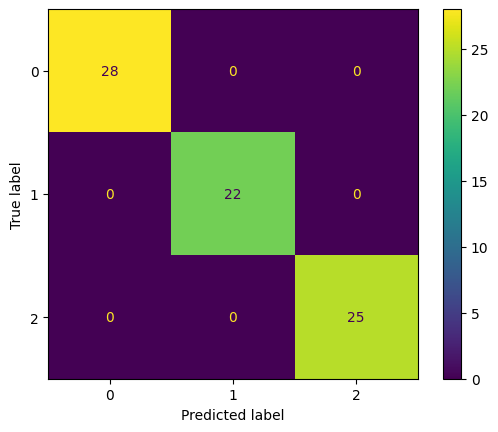

In [113]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(y_actual, y_predict)
cmDisp = ConfusionMatrixDisplay(confusion_matrix=cm)
cmDisp.plot()
plt.show()

5. Saving Model Weights

In [90]:
MODEL_PATH = os.path.join("../action-recognition/models")

In [91]:
model.save(os.path.join(MODEL_PATH, "model_1.h5"))

## Real Time Testing

In [51]:
from collections import deque
from concurrent.futures import ThreadPoolExecutor
from time import time
from cvzone import FPS

In [54]:
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Detectors
handDetector = HandDetector(detectionCon=0.5, maxHands=2)
faceDetector = FaceDetector(minDetectionCon=0.5)
poseDetector = PoseDetector(detectionCon=0.5)

fpsReader = FPS()

timeStats = []

try:

    keypointsHistory = deque()
    predictionHistory = deque()
    detectionThreshold = 1.0

    lastPredictionTime = time()
    predictionCooldown = 1

    while True:
        startTime = time()

        # Read from camera
        success, frame = cam.read()
        if not success: 
            raise Exception("No Frames Read")
        frame = cv2.flip(frame, 1)

        # Pose Detection
        detectionResults, frame = featureExtraction(
            handDetector, faceDetector, poseDetector, frame)
        
        # Semantic Prediction
        keypointsHistory.append(detectionResults)
        if len(keypointsHistory) > frames_per_training:
            keypointsHistory.popleft()

            
            # if time() > lastPredictionTime + predictionCooldown:
            #     predictionResults = model.predict(
            #         np.expand_dims(keypointsHistory, axis=0), 
            #         verbose=0, 
            #         use_multiprocessing=True, 
            #         workers=4
            #         )[0]
            #     predWord = action_labels[np.argmax(predictionResults)]
            #     predAccuracy = predictionResults[np.argmax(predictionResults)]

            #     if predAccuracy >= detectionThreshold:
            #         lastPredictionTime = time()
                    
            #         predictionHistory.append(predWord)
            #         if len(predictionHistory) > 5:
            #             predictionHistory.popleft()
        
        cv2.putText(frame, ', '.join(predictionHistory), (15, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
        
        fps, frame = fpsReader.update(frame,pos=(950,80),color=(0,255,0),scale=5,thickness=5)


        # Show resulting frame
        # cv2.putText(frame, f'Training #{training + 1} for \'{action}\'', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
        cv2.imshow("Sign Language Recognition Prototype", frame)     

        timeStats.append(time() - startTime)

        keyPressed = cv2.waitKey(15)
        # Stop Program when pressed 'Esc'
        if (keyPressed == 27):
            raise Exception("Finished")


except Exception as e:
    cam.release()
    cv2.destroyAllWindows()
    print(e)

cam.release()
cv2.destroyAllWindows()

Finished


In [50]:
timeStats[10:]

[0.07875680923461914,
 0.07371330261230469,
 0.0756688117980957,
 0.07382822036743164,
 0.07182097434997559,
 0.14654779434204102,
 0.13663458824157715,
 0.13762927055358887,
 0.13364148139953613,
 0.173537015914917,
 0.16253042221069336,
 0.16656756401062012,
 0.1545863151550293,
 0.1565384864807129,
 0.16048026084899902,
 0.1515054702758789,
 0.1635282039642334,
 0.17353558540344238,
 0.15356874465942383,
 0.15557503700256348,
 0.15255475044250488,
 0.1715106964111328,
 0.15854263305664062,
 0.15158939361572266,
 0.1595776081085205,
 0.16945433616638184]

In [72]:
from concurrent.futures import ThreadPoolExecutor


# Detects hands, face & pose, 
# convert them into normalized landmark/keypoint coordinates in a 1D-array, 
# and also returns the frame with the landmark connections drawn onto it
def featureExtractionV2(handDetector, faceDetector, poseDetector, frame):
    results = {}
    frameSize = (frame.shape[1], frame.shape[0])

    def detectHands(frame, handDetector, frameSize):
        results = {}
        # Hand Detection
        results['hands'], frame = handDetector.findHands(frame, draw=True)
        if not results['hands']:
            results['hands'] = [generate_empty_hand('Left'), generate_empty_hand('Right')]
        elif len(results['hands']) == 1:
            results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
            
            if (results['hands'][0]['type'] == 'Left'):
                results['hands'].append(generate_empty_hand('Right'))
            else:
                results['hands'].insert(0, generate_empty_hand('Left'))                         
        else:
            results['hands'][0] = preprocess_body_part(results['hands'][0], frameSize)
            results['hands'][1] = preprocess_body_part(results['hands'][1], frameSize)
        return results['hands']

    def detectPose(frame, poseDetector, frameSize):
        results = {}
        # Pose Detection
        # * We only use the first 23 out of the total 33 landmark points 
        #   as those represent the lower half body and are irrelevant
        frame = poseDetector.findPose(frame, draw=True)
        results['pose'] = {}
        results['pose']['lmList'], tempPoseBbox = poseDetector.findPosition(frame, bboxWithHands=False)
        if results['pose']['lmList'] and tempPoseBbox:
            results['pose']['lmList'] = results['pose']['lmList'][:23]
            results['pose']['bbox'] = tempPoseBbox['bbox']
            results['pose']['center'] = tempPoseBbox['center']
            results['pose'] = preprocess_body_part(results['pose'], frameSize)
        else:
            results['pose']['lmList'] = np.zeros(23 * 3, dtype=int)
            results['pose']['bbox'] = np.zeros(4, dtype=float)
            results['pose']['center'] = np.zeros(2, dtype=float)
        return results['pose']
            

    def detectFace(frame, faceDetector, frameSize):
        results = {}
        # Face Detection
        frame, results['face'] = faceDetector.findFaces(frame, draw=True)
        if results['face']:
            results['face'] = select_best_matching_face(results['face'], frameSize)
            results['face']['bbox'] = preprocess_bbox(results['face']['bbox'], frameSize)
            results['face']['center'] = preprocess_center(results['face']['center'], frameSize)
        else:
            results['face'] = {
                'bbox': np.zeros(4, dtype=float), 
                'center': np.zeros(2, dtype=float)
            }
        return results['face']
    
    with ThreadPoolExecutor() as executor:
        t1 = executor.submit(detectHands, frame, handDetector, frameSize)
        t2 = executor.submit(detectPose, frame, poseDetector, frameSize)
        t3 = executor.submit(detectFace, frame, faceDetector, frameSize)


        # Convert results into 1D-array
        detectionResults = np.concatenate([
            flattenDetectionResult(t1.result()[0]), 
            flattenDetectionResult(t1.result()[1]), 
            flattenDetectionResult(t2.result()), 
            t3.result()['bbox'], 
            t3.result()['center']
        ])

        return detectionResults, frame

In [73]:
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

fpsReader = FPS()

timeStats = []

try:
    initialTime = time()
    while True:
        startTime = time()

        # Read from camera
        success, frame = cam.read()
        
        # Pose Detection
        detectionResults, frame = featureExtractionV2(
            handDetector, faceDetector, poseDetector, frame)
        
        fps, frame = fpsReader.update(frame,pos=(50,80),color=(0,255,0),scale=5,thickness=5)


        # Show resulting frame
        # cv2.putText(frame, f'Training #{training + 1} for \'{action}\'', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
        cv2.imshow("Sign Language Recognition Prototype", frame)     

        timeStats.append(time() - startTime)

        keyPressed = cv2.waitKey(15)
        # Stop Program when pressed 'Esc'
        if (keyPressed == 27):
            raise Exception("Finished")
        
        if time() - initialTime > 5:
            raise Exception()


except Exception as e:
    cam.release()
    cv2.destroyAllWindows()
    print(e)

cam.release()
cv2.destroyAllWindows()

Finished


In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [67]:
np.array(timeStats[1:]).mean()

0.016924326368373075

In [64]:
np.array(timeStats[1:]).mean()

0.09001387300945464

In [74]:
np.array(timeStats[1:]).mean()

0.06750456676926724